# Plot predictions and data for best parameter combination

### import modules

In [1]:
%matplotlib inline

In [2]:
import os
import fnmatch

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics
from nilearn import plotting

import pickle

In [3]:
sns.set_style('white')
sns.set_context('poster')

### load labeler

In [4]:
myLabeler = pickle.load( open('../models/myLabeler.p','rb') )

In [5]:
myLabeler.classes_

array(['bilateral', 'inconclusive', 'left', 'right'], dtype=object)

### load list with patients

In [6]:
my_nest = pickle.load( open('../models/my_nest.p','rb'))
my_test = pickle.load( open('../models/my_test.p','rb'))

In [7]:
my_all = my_nest + my_test

In [8]:
len(my_all)

783

### get Wilke data

In [9]:
def getWilkeLIs(myDir):
    fileList = ['%s%s'%(myDir,x) for x in os.listdir(myDir) if x.startswith('All') and x.endswith('.txt')]

    print fileList
    wilkeDf = pd.DataFrame()

    for f in fileList:
        liName = f.split('All')[-1].split('.')[0]
        liName = liName[0].lower()+liName[1:]
        thisDf = pd.read_csv(f,sep='\t')
        thisDf.index = [ x.split('tMap_')[-1].split(' (')[0] for x in thisDf['Input image'] ]

        try:
            thisDf = pd.DataFrame(thisDf['LI'])
            thisDf.columns=[liName]
        except:
            thisDf = pd.DataFrame(thisDf[['LI (overall)','LI_T25 (overall)','LI (wm)']])
        
        wilkeDf = pd.concat([wilkeDf,thisDf],axis=1)
    wilkeDf.sort_index(axis=1,inplace=True)
    
    return wilkeDf

In [10]:
wilkeDf = getWilkeLIs('../data/processed/li_tool/')

['../data/processed/li_tool/AllAdaptMeanLI.txt', '../data/processed/li_tool/AllBootLI.txt', '../data/processed/li_tool/AllFixedCountLI.txt', '../data/processed/li_tool/AllFixedMeanLI.txt']


In [ ]:
wilkeDf.tail()

In [12]:
newColNames = { 'LI_T25 (overall)':'bootstrap-trimmed',
                'adaptMeanLI':'adaptive',
                'LI (wm)':'bootstrap-weighted',
                'fixedCountLI':'fixed-count',
                'fixedMeanLI':'fixed-mean',
                'LI (overall)':'bootstrap'}

In [13]:
wilkeDf.rename(columns=newColNames,inplace=True)

### add clinical judgement

In [14]:
clinDf = pd.read_csv('../data/raw/csv/clinData.csv',index_col=[0])
clinDf = clinDf[clinDf['n_vols']==200]
clinDf = clinDf[clinDf['problems']==0]
clinDf = clinDf.groupby(level=0).last()
clinDf.dropna(inplace=True)

In [15]:
mergeDf = pd.concat([clinDf['clin'],wilkeDf],axis=1)
mergeDf.index = [mergeDf.clin,mergeDf.index]
mergeDf.drop('NaN',level=0,inplace=True)
mergeDf.sort_index(inplace=True)

In [ ]:
mergeDf.tail()

In [19]:
mergeDf.to_csv('../data/processed/li_tool/allWilkeData.csv')

### split into train and test

In [20]:
df_nest = mergeDf.loc[my_nest].sort_index()
df_test = mergeDf.loc[my_test].sort_index()

In [67]:
print df_nest.shape, df_test.shape

(521, 7) (262, 7)


### get features and labels

In [21]:
def makeXy(df,thresh,myLabeler=myLabeler):
    
    # select the data
    thisDf = pd.DataFrame( df[thresh] )

    # make int labels
    labels = [ thisDf.index.levels[0][x] for x in thisDf.index.labels[0] ]
    y = myLabeler.fit_transform(labels)

    # put features into matrix
    X = np.array( thisDf ).reshape(-1,thisDf.shape[-1])
    
    return X,y

In [22]:
X_train,y_train = makeXy(df_nest,'bootstrap')
X_test,y_test = makeXy(df_test,'bootstrap')

### get rid of nans for training

In [23]:
def dropNans(X,y):
    # get rid of nans for (because they throw an error when we try to fit the classifier)
    
    # this works also for multi-feature X (each observation row has multiple columns/features)
    noNanTrain = np.where(np.isnan(X).sum(axis=1)==False)
    
    # X and y need to be changed, otherwise the order of real and predicted labels
    # will not match
    X = X[noNanTrain[0]]
    y = y[noNanTrain[0]]
    return X,y

In [24]:
X_train,y_train = dropNans(X_train,y_train)

### decide if inconclusive data should be included

In [25]:
def dropInc(X,y,myLabeler=myLabeler):

    # here, we use the labels (y) to find and exclude inconclusive cases
    noInc = np.where(y!=myLabeler.transform(['inconclusive'])[-1])
    
    # both X and y need to be changed
    X = X[noInc[0]]
    y = y[noInc[0]]
    
    return X,y

### fit the classifier using training data

In [26]:
def makeFit(X_train,y_train):
    
    scaler = preprocessing.StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    clf = svm.SVC(kernel='linear', C=1.0, probability=True,random_state=0)
    clf.fit(X_train_std,y_train)
    
    return clf,scaler

In [27]:
from sklearn import svm

In [28]:
clf,scaler = makeFit(X_train,y_train)

### predictions for one value and one parameter set

In [29]:
def makePred(x,clf,scaler,myLabeler=myLabeler):
    
    xArr = np.array(x)
    xScaled = scaler.transform( xArr.reshape(1,-1*xArr.shape[-1]) )

    y_pred = clf.predict_proba(xScaled)
    
    df = pd.DataFrame(y_pred).T
    idx = [myLabeler.inverse_transform([x])[-1] for x in clf.classes_]
    df.index = idx
    
    return df

Example:

In [30]:
thesePreds = makePred([0],clf,scaler)

/data/martin/frontSub/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [31]:
thesePreds

0
bilateral     0.251194
inconclusive  0.495953
left          0.206614
right         0.046239

### settings for nice plots

here, we assign each group a consistent color:  
- left: red
- bilateral: green
- right: blue
- inconclusive: grey

Also, we use the seaborn color_palette to get in-between muted colors which are not so loud

In [32]:
# first, we put the colors in a dict, so there is a clear mapping of group to color
cDict = {}
for group,color in zip(myLabeler.classes_,['Greens','Greys','Reds','Blues']):
    cDict[group] = sns.color_palette(color,4)[-2]
# then, we make a sorted list, in case we need this, which is ordered in the same way as our labeler object
cList = []
for group in myLabeler.classes_:
    cList.append( cDict[group] )

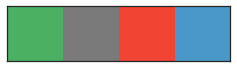

In [33]:
sns.palplot(cList)

### getting the order of cases right, so colors and labels line up

In [34]:
def makeIncCase(myLabeler):
    a = np.array([0.,0.,0.,0.])
    for i,j in enumerate(myLabeler.classes_):
        if j =='inconclusive':
            a[i] = 1.
    return a

In [35]:
makeIncCase(myLabeler)

array([ 0.,  1.,  0.,  0.])

In [36]:
def makeCase(thesePreds,myLabeler):
    a = np.array([0.,0.,0.,0.])
    for i,j in enumerate(myLabeler.classes_):
        try:
            a[i] = thesePreds.loc[j].values[-1]
        except:
            pass
    return a

In [37]:
myPreds = makeCase(thesePreds,myLabeler)

In [38]:
myPreds

array([ 0.25119435,  0.49595272,  0.2066137 ,  0.04623922])

turn 4-case values into 3-value RGB for plotting

In [39]:
def cmyk2rgb(c2,c4,c1,c3):
    
    c=float(c1)#/100.
    m=float(c2)#/100.
    y=float(c3)#/100.
    k=float(c4)#/100.
    
    r=round(255.0 - ((min(1.0,c*(1.0-k)+k))*255.0))
    g=round(255.0 - ((min(1.0,m*(1.0-k)+k))*255.0))
    b=round(255.0 - ((min(1.0,y*(1.0-k)+k))*255.0))
    
    # mute the colors so they don't look as loud
    r= round(r*0.6+10*0.4)
    g= round(g*0.6+10*0.4)
    b= round(b*0.6+10*0.4)
    
    return [r,g,b]

In [40]:
cmyk2rgb(*myPreds)

[65.0, 62.0, 78.0]

### make swarmplot

In [41]:
def makeSnsDf(maxDf):
    snsDf = pd.DataFrame(maxDf)
    snsDf.columns = ['y']
    snsDf['hue'] = [snsDf.index.levels[0][x] for x in snsDf.index.labels[0]]
    snsDf['x'] = [0 for x in snsDf.index]
    return snsDf

In [42]:
snsDf = makeSnsDf(mergeDf['bootstrap'])

In [68]:
snsDf.shape

(783, 3)

In [ ]:
snsDf.tail()

In [44]:
theseColors = [cDict[x] for x in snsDf.index.levels[0]]

### add the background color which codes the probability of each class for this value

Example of conversion into RGB Colors

In [45]:
myPreds = makeCase(thesePreds,myLabeler)
cmyk2rgb(*myPreds)

[65.0, 62.0, 78.0]

### do this for the whole parameter space

Example:

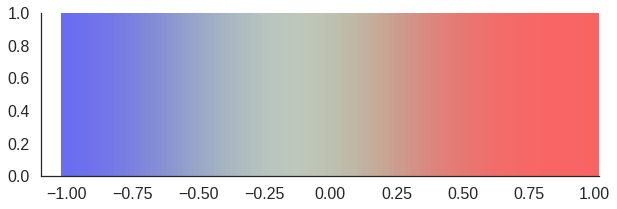

In [46]:
plt.figure(figsize=(10,3))
for i in np.linspace(-1,1,101):
    thesePreds = makePred([i],clf,scaler)
    myPreds = makeCase(thesePreds,myLabeler)
    thisRgb = cmyk2rgb(*myPreds)
    #print thisRgb
    formatRgb = 1-(np.array(thisRgb)/255.)
    #print formatRgb
    plt.axvline(i,color=tuple(formatRgb),linewidth=10)
sns.despine()
plt.show()

### combine data and background

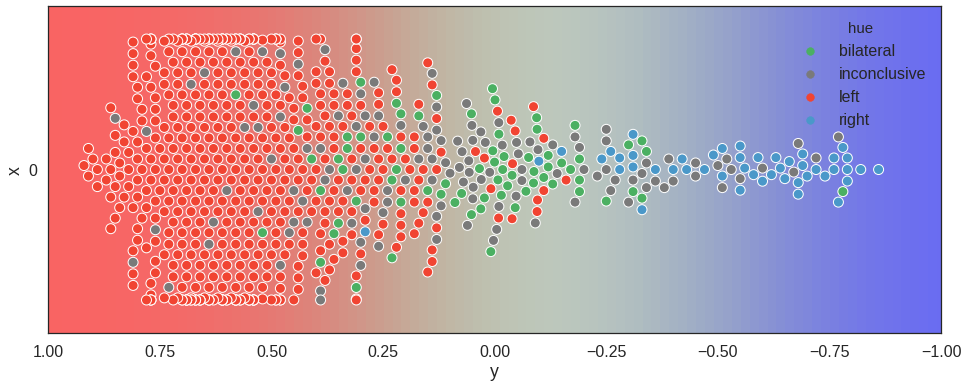

In [47]:
fig,ax = plt.subplots(1,1,figsize=(16,6))

sns.swarmplot(data=snsDf,x='y',y='x',hue='hue',
              orient='h',
              palette=theseColors,
              size=10,
              edgecolor='white',
              linewidth=1,
              ax=ax)

for i in np.linspace(-1,1,101):
    thesePreds = makePred([i],clf,scaler)
    myPreds = makeCase(thesePreds,myLabeler)
    thisRgb = cmyk2rgb(*myPreds)

    formatRgb = 1-(np.array(thisRgb)/255.)

    ax.axvline(i,color=tuple(formatRgb),linewidth=10)

ax.set_xlim(1,-1,-0.1)
plt.show()

### plot the probabilities as curves instead of as colors

In [48]:
def makeProbPreds(clf,scaler):
    df = pd.DataFrame()
    for i in np.linspace(-1,1,1001):
        thesePreds = makePred([i],clf,scaler)
        thesePreds = thesePreds.T
        thesePreds.index = [i]
        df = pd.concat([df,thesePreds])
    return df

In [49]:
probPredsDf = makeProbPreds(clf,scaler)

In [50]:
probPredsDf.tail()

bilateral  inconclusive      left     right
0.992   0.002592      0.008213  0.989183  0.000011
0.994   0.002561      0.008123  0.989305  0.000011
0.996   0.002530      0.008034  0.989425  0.000011
0.998   0.002499      0.007946  0.989544  0.000011
1.000   0.002469      0.007859  0.989662  0.000011

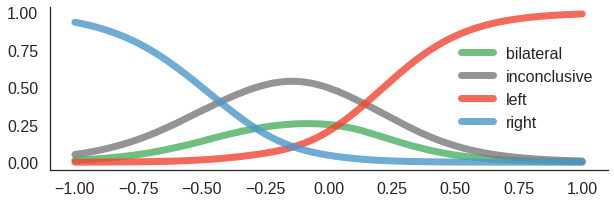

In [51]:
plt.figure(figsize=(10,3))
for i in probPredsDf.columns:
    plt.plot( probPredsDf[i], c=cDict[i],label=i,linewidth=7,alpha=0.8 )
plt.legend(loc='best')
sns.despine()
plt.show()

### do everything

In [52]:
def makeAllAcc(df_nest,liType,myDrop):
    
    # get training data
    X_train,y_train = makeXy(df_nest,liType)
    # remove nans from training data
    X_train,y_train = dropNans(X_train,y_train)

    
    # decide if we want to include inconclusive cases
    if myDrop:
        X_train,y_train = dropInc(X_train,y_train)
    
    # fit classifier using training data
    clf,scaler = makeFit(X_train,y_train)

    return clf,scaler

In [53]:
clf,scaler = makeAllAcc(df_nest,'bootstrap',True)

In [54]:
d = {}
for c in mergeDf.columns.drop('clin'):
    d[c] = {}
    for myDrop in [True, False]:
        clf,scaler = makeAllAcc(df_nest,c,myDrop)
        d[c][myDrop] = {'clf':clf,'scaler':scaler}

In [55]:
d

{'adaptive': {False: {'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
     max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
     verbose=False),
   'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)},
  True: {'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
     max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
     verbose=False),
   'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}},
 'bootstrap': {False: {'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
     max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
     verbose=False),
   'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)},
  True: {

In [56]:
pickle.dump(d,open('../models/li_tool_clf.p','wb'))

## make the 1d plot

### first part: the swarmplot with the data

In [57]:
def makeSwarm(snsDf, probPredsDf, ax):

    # first element: the data as a swarmplot

    snsDf.sort_index(inplace=True)
    theseColors = [
        cDict[x] for x in snsDf.index.remove_unused_levels().levels[0]
    ]

    sns.swarmplot(
        data=snsDf,
        x='y',
        y='x',
        hue='hue',
        orient='h',
        palette=theseColors,
        size=8,
        edgecolor='white',
        linewidth=1,
        ax=ax)

    # second element: the background
    for i in np.linspace(-1,1,1001):
        thesePreds = makePred([i],clf,scaler)
        myPreds = makeCase(thesePreds,myLabeler)
        thisRgb = cmyk2rgb(*myPreds)
        formatRgb = 1-(np.array(thisRgb)/255.)
        ax.axvline(i,color=tuple(formatRgb),linewidth=10)

    # get rid of axes labels
    ax.set_xlim(1.01, -1.01, -0.2)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_ylim(-0.36, 0.36)
    ax.legend_.remove()
    
    return ax

### second part: probability curves

In [58]:
def makeProbCurves(probPredsDf,ax,cDict=cDict):
        
    for i in probPredsDf.columns:
        ax.plot( probPredsDf[i], c=cDict[i],label=i,linewidth=7,alpha=0.8 )

    ax.set_xlim(1.01,-1.01,-0.2)
    ax.set_xticks(np.arange(1.0,-1.01,-0.2))
    ax.set_xticklabels(['%.1f'%x for x in np.arange(1.0,-1.01,-0.2)],fontsize=28)
    ax.set_xlabel('Laterality Index',fontsize=28)
    ax.set_yticks([0,1])
    ax.set_yticklabels([0,1],fontsize=28)
    ax.set_ylabel('p(Class)',fontsize=28)
    ax.set_ylim(-0.03,1.03)

    return ax

### combination of both

In [59]:
def makeFullPlot(snsDf, probPredsDf, myTitle, makeLegend=False):

    # make the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # first subplot: the data and the color background
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
    ax1 = makeSwarm(snsDf, probPredsDf, ax1)

    # plot legend
    if makeLegend:
        # make font of legend white
        legend = plt.legend(frameon=1)
        frame = legend.get_frame()
        frame.set_facecolor('white')

    # second subplot: the probability curves
    ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
    ax2 = makeProbCurves(probPredsDf, ax2)

    sns.despine()
    plt.suptitle(myTitle, y=.92, fontsize=32)
    plt.show()
    return fig

### function to get the data and feed them into figure function

In [60]:
def bigPlotMaker(mergeDf,my_nest,whichLI,drop=True,makeLegend=False):
    
    df_nest = mergeDf.loc[my_nest].sort_index()
    
    clf,scaler = makeAllAcc(df_nest,whichLI,drop)
                     
    # load the data
    allAvgLiDf = pd.DataFrame( mergeDf[whichLI] )
    
    probPredsDf = makeProbPreds(clf,scaler)
        
    # get the data into seaborn-friendly format
    snsDf = makeSnsDf(allAvgLiDf)
    if drop:
        snsDf.drop('inconclusive',inplace=True)
    snsDf.index = snsDf.index.remove_unused_levels()
    
    # make the plot
    if drop:
        dropStr = ', without inconclusive cases'
    else:
        dropStr = ', with inconclusive cases'
        
    fig = makeFullPlot(snsDf,probPredsDf,whichLI+dropStr,makeLegend=makeLegend)
    
    return fig

In [61]:
sns.set_style('white')

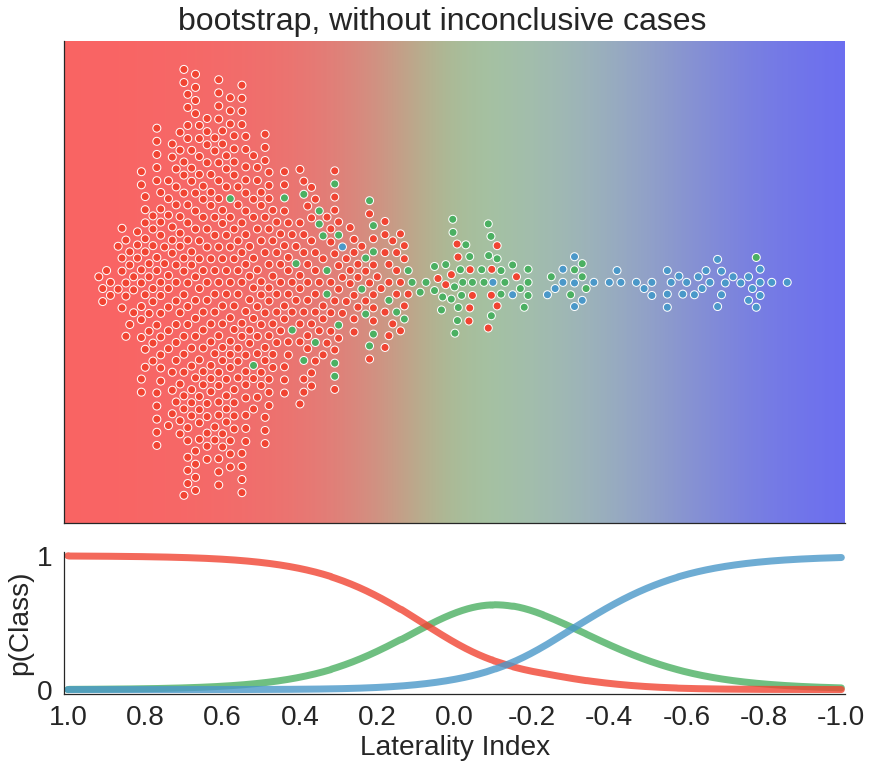

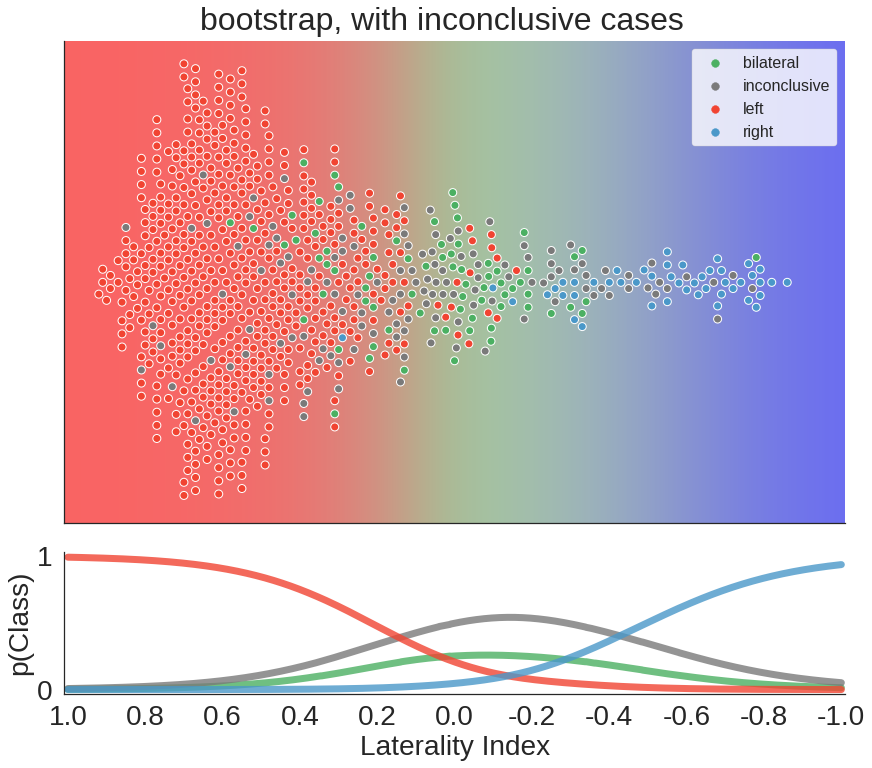

In [62]:
for c in ['bootstrap']:
    for myDrop in [True, False]:
        dropStr = ['full', 'drop'][myDrop]
        fig = bigPlotMaker(mergeDf, my_nest, c, drop=myDrop,makeLegend=(myDrop==False))
        fig.savefig(
            '../temp/14-swarm-1d-%s-%s.png' % (c, dropStr),
            dpi=300,
            bbox_inches='tight')

In [63]:
figs = ['../temp/%s'%f for f in os.listdir('../temp/') if f.startswith('14-swarm-1d-boot')]
figs

['../temp/14-swarm-1d-bootstrap-drop.png',
 '../temp/14-swarm-1d-bootstrap-full.png']

In [64]:
sns.set_style('dark')

In [65]:
fig = plt.figure(figsize=(64, 28))

for i, imName in enumerate(figs):
    ax = plt.subplot(1,2,i+1)
    ax.imshow(plt.imread(imName))

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.close()

fig.savefig('../reports/figures/14-swarm-1d-bootstrap.png',dpi=300,bbox_inches='tight')

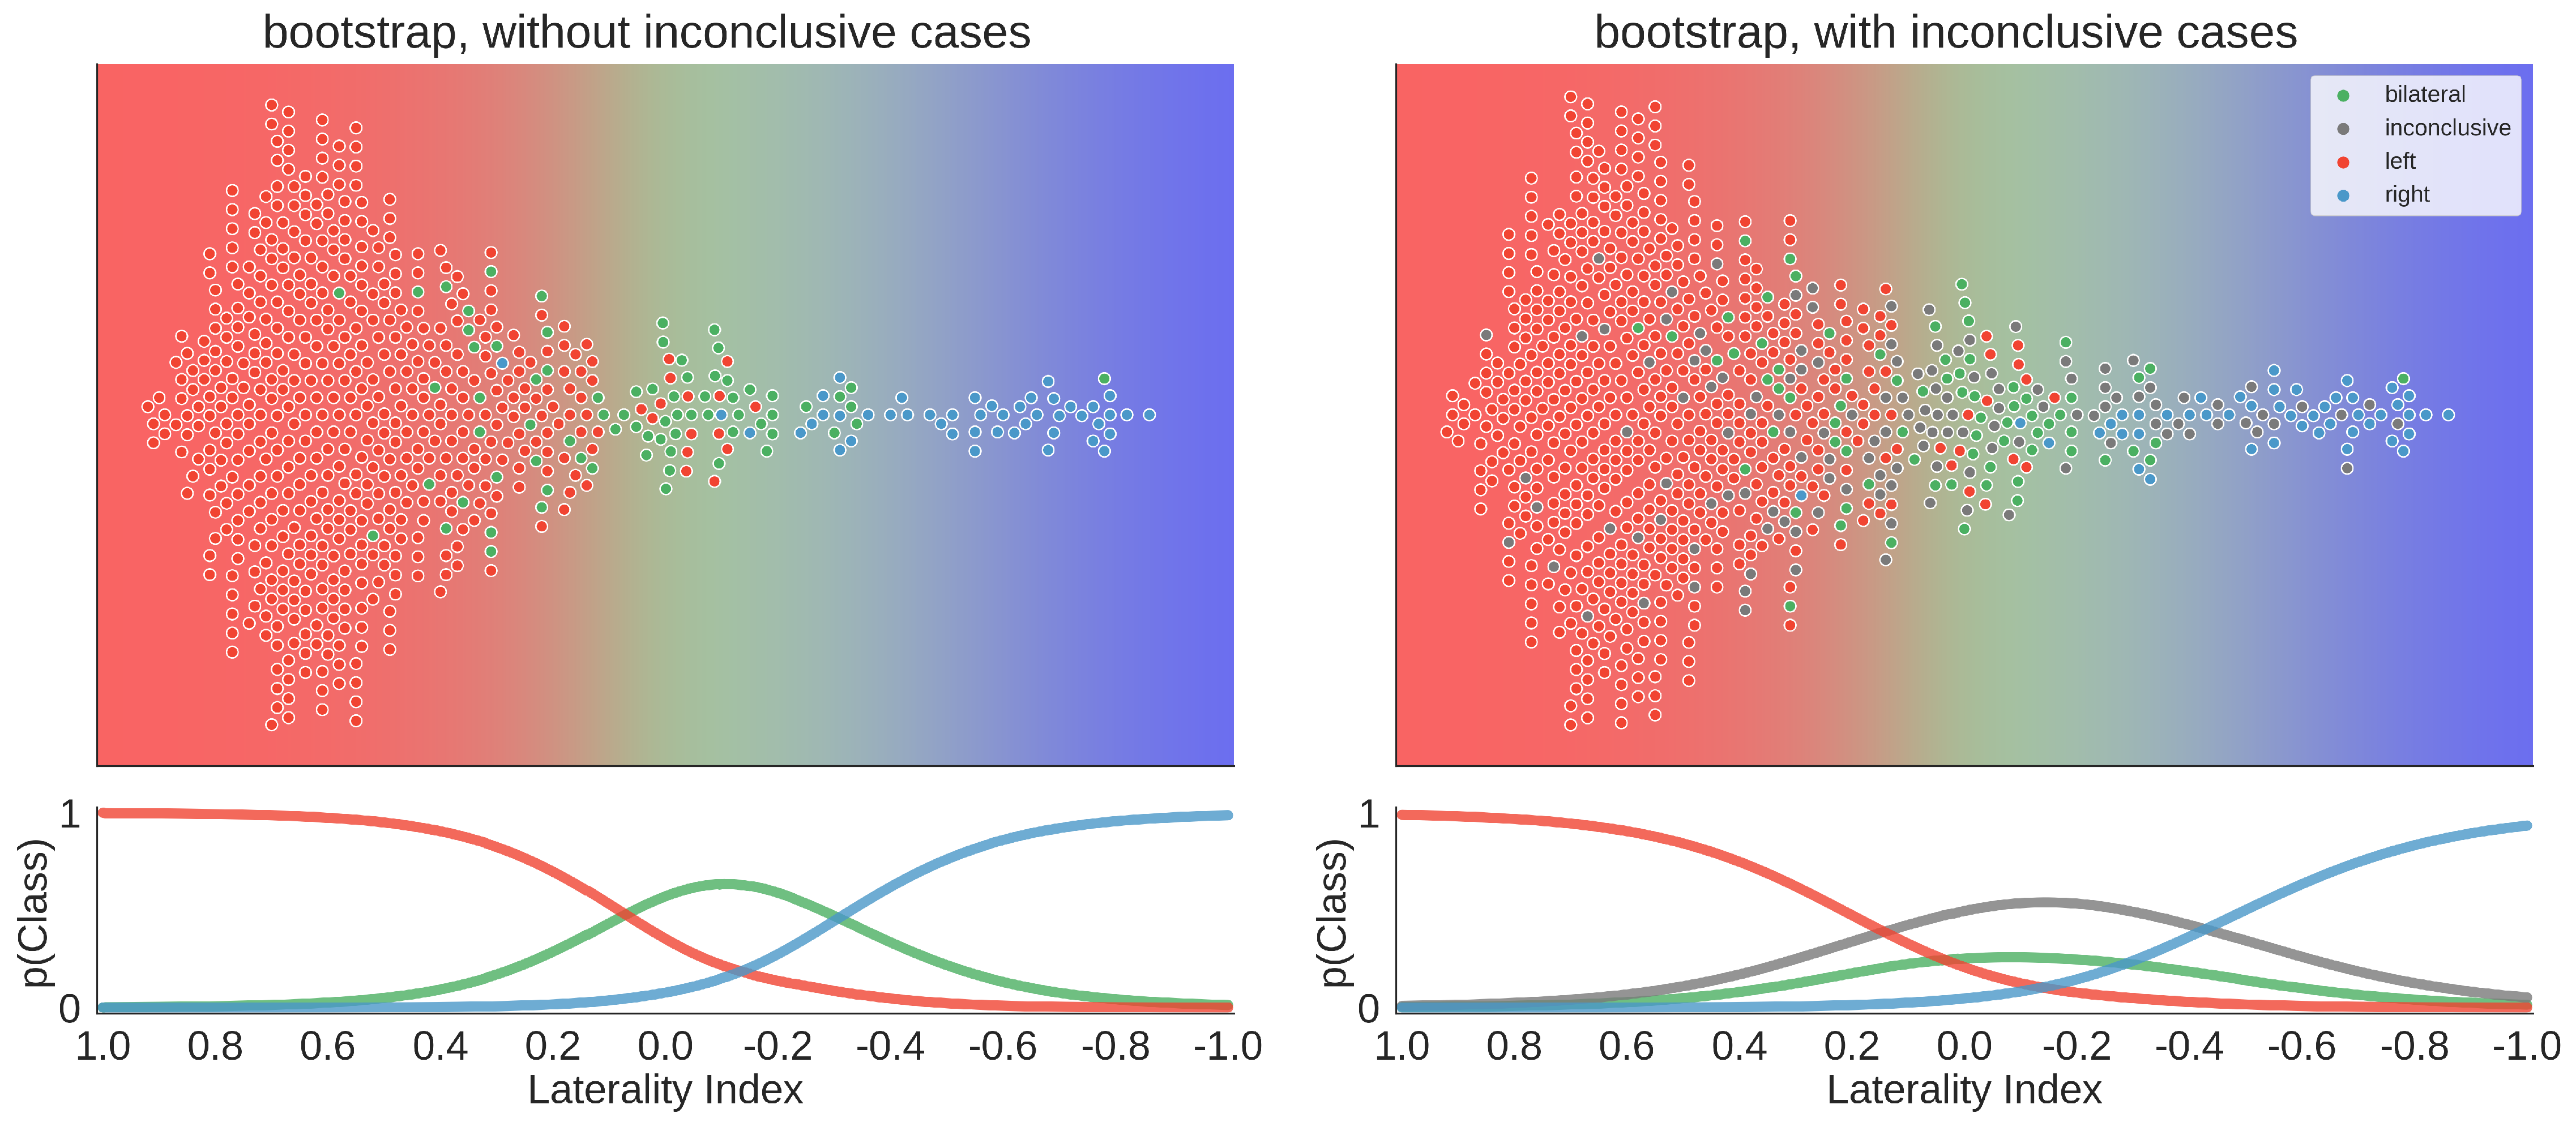

In [66]:
fig

## Show all versions

In [69]:
sns.set_style('white')

bootstrap True


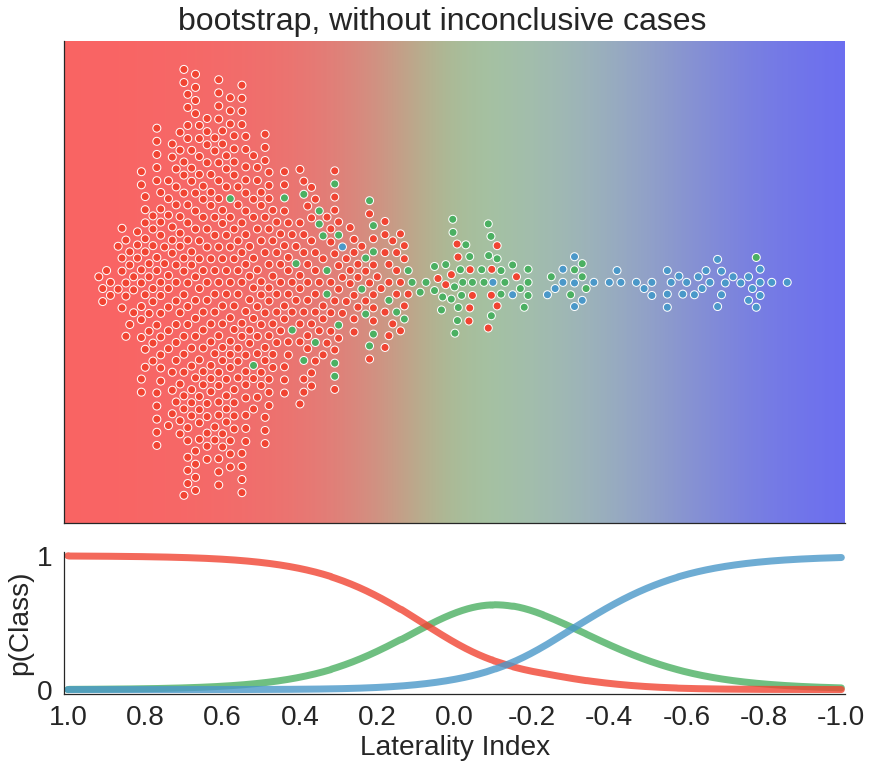

bootstrap False


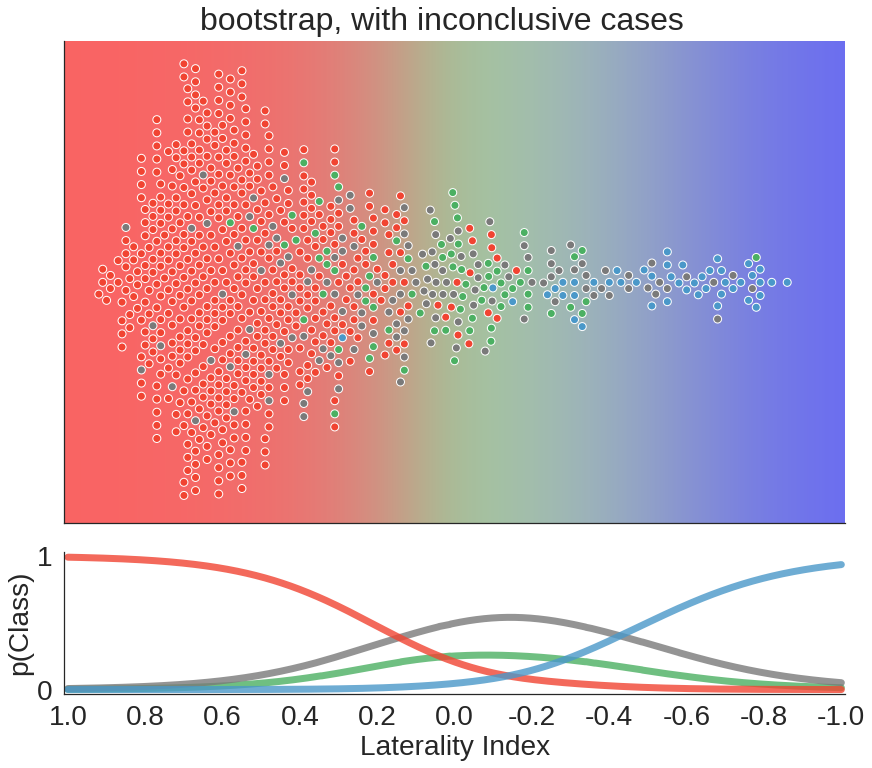

bootstrap-weighted True


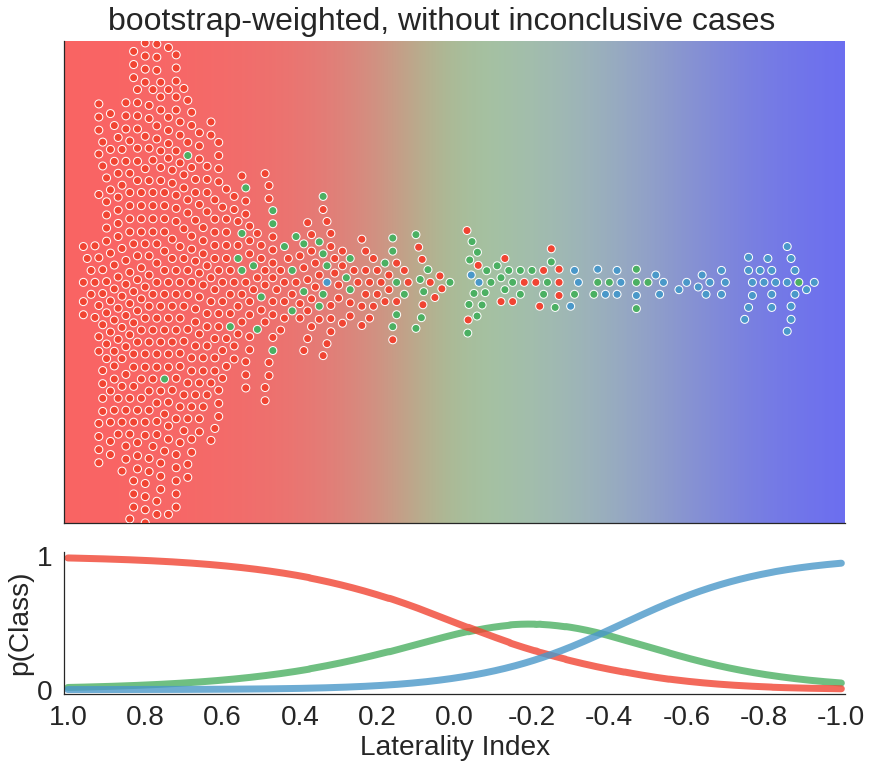

bootstrap-weighted False


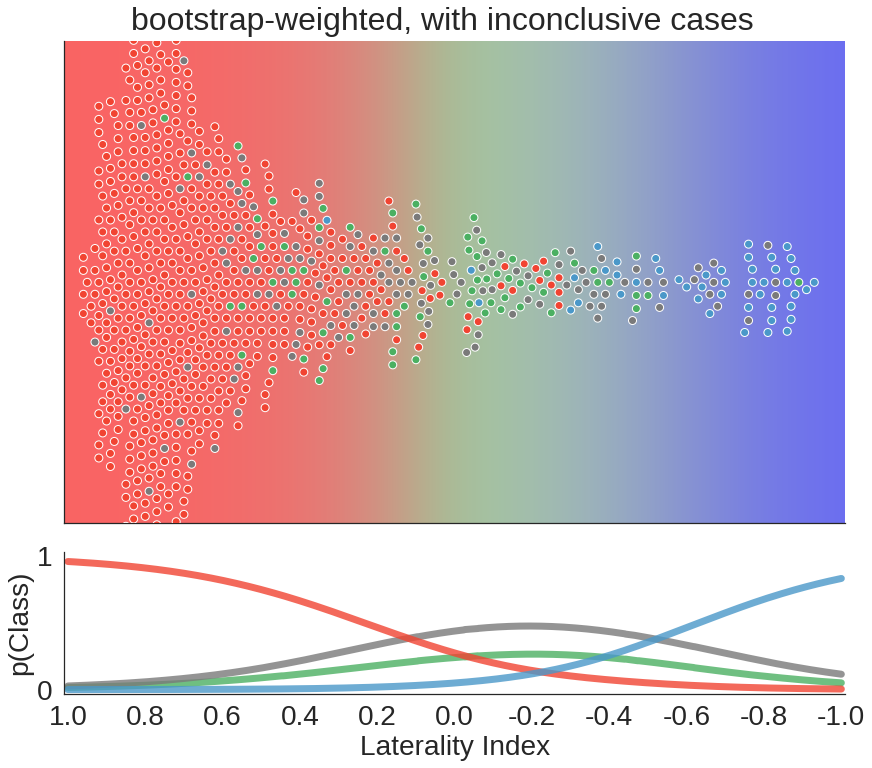

bootstrap-trimmed True


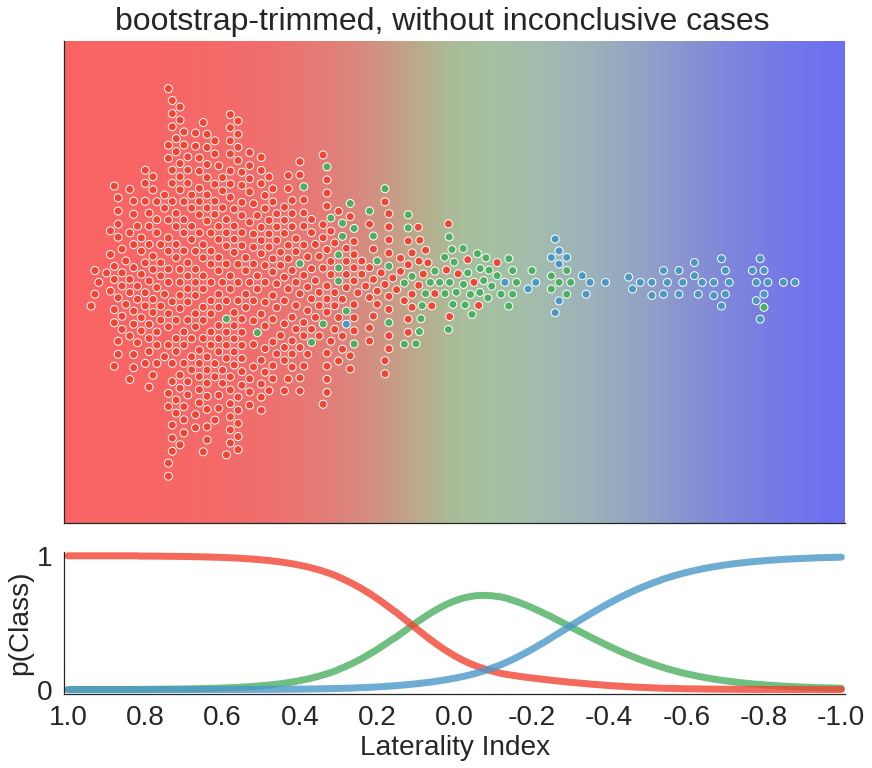

bootstrap-trimmed False


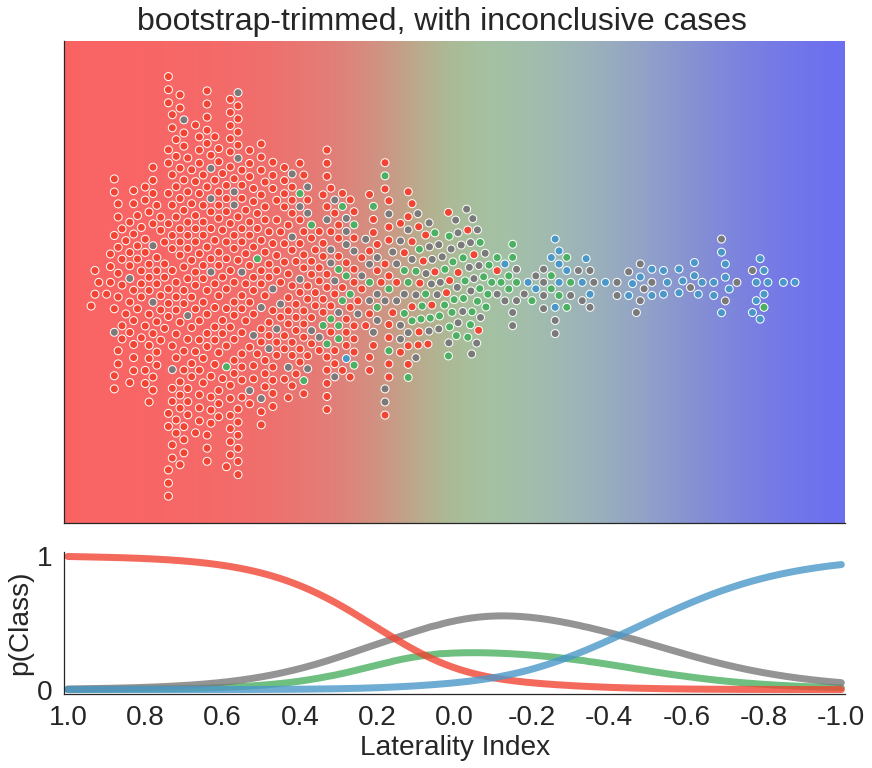

adaptive True


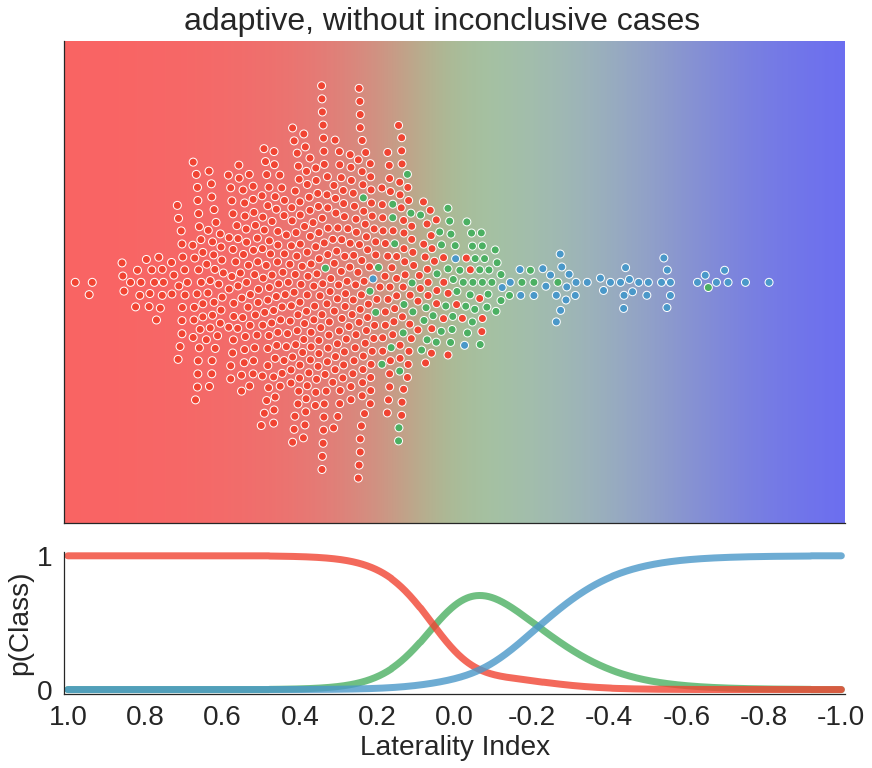

adaptive False


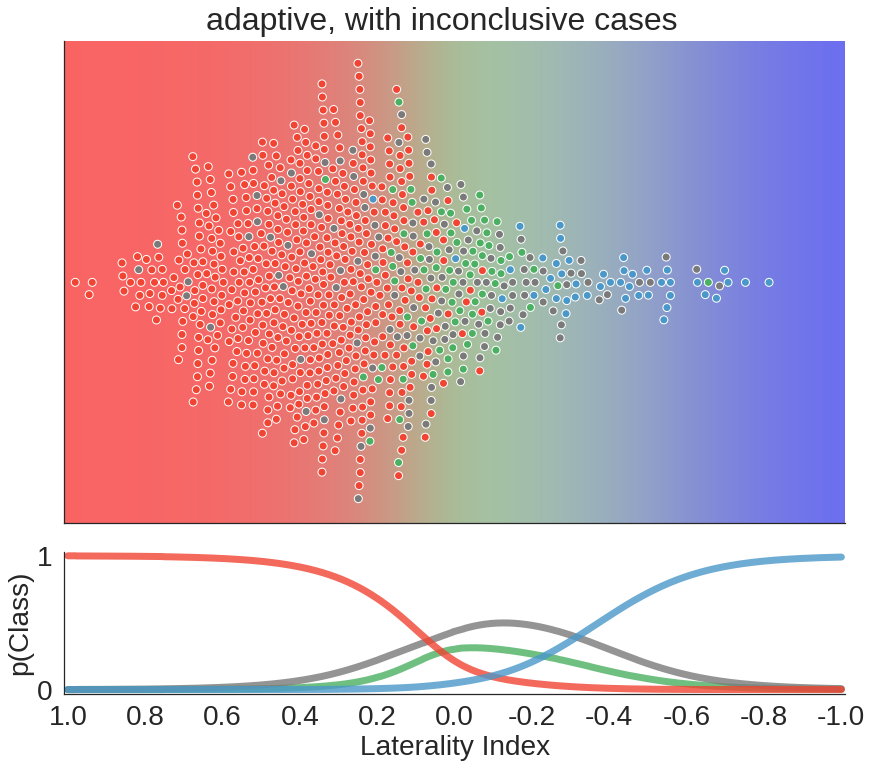

fixed-count True


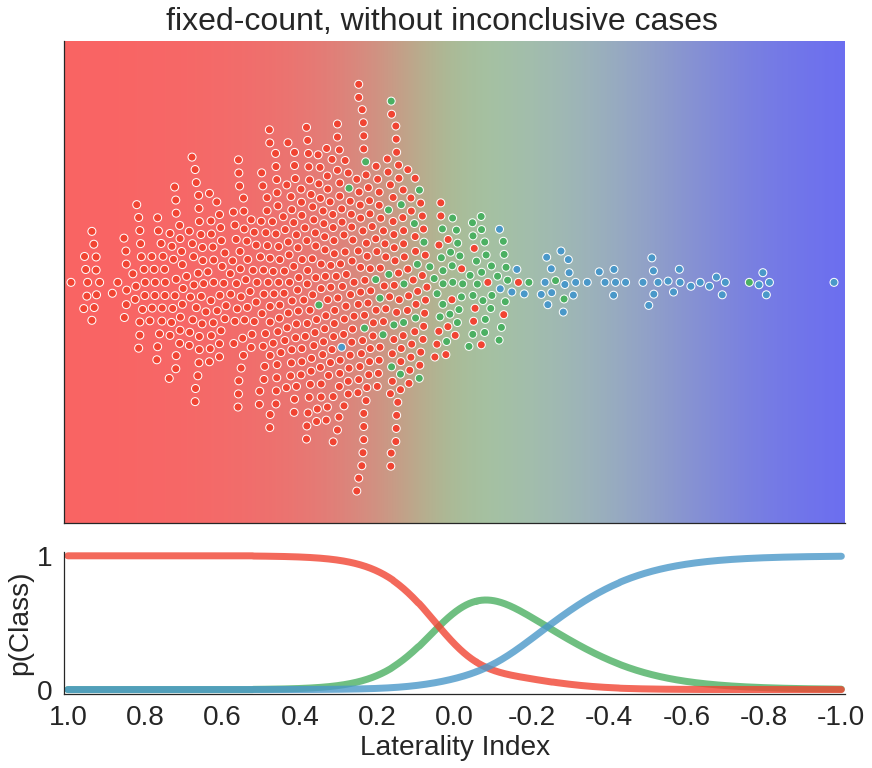

fixed-count False


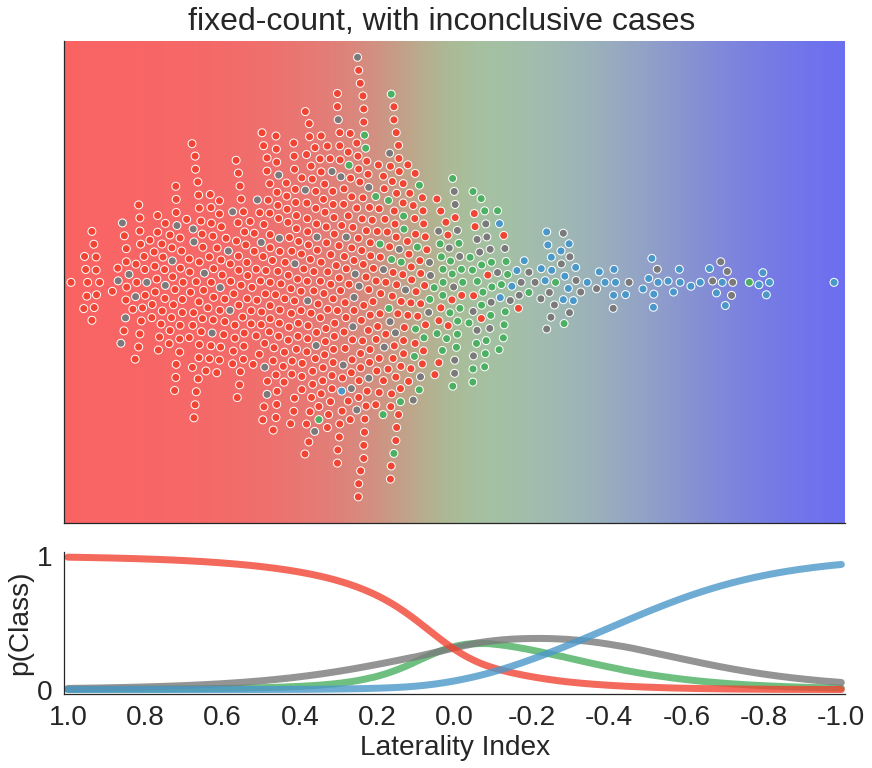

fixed-mean True


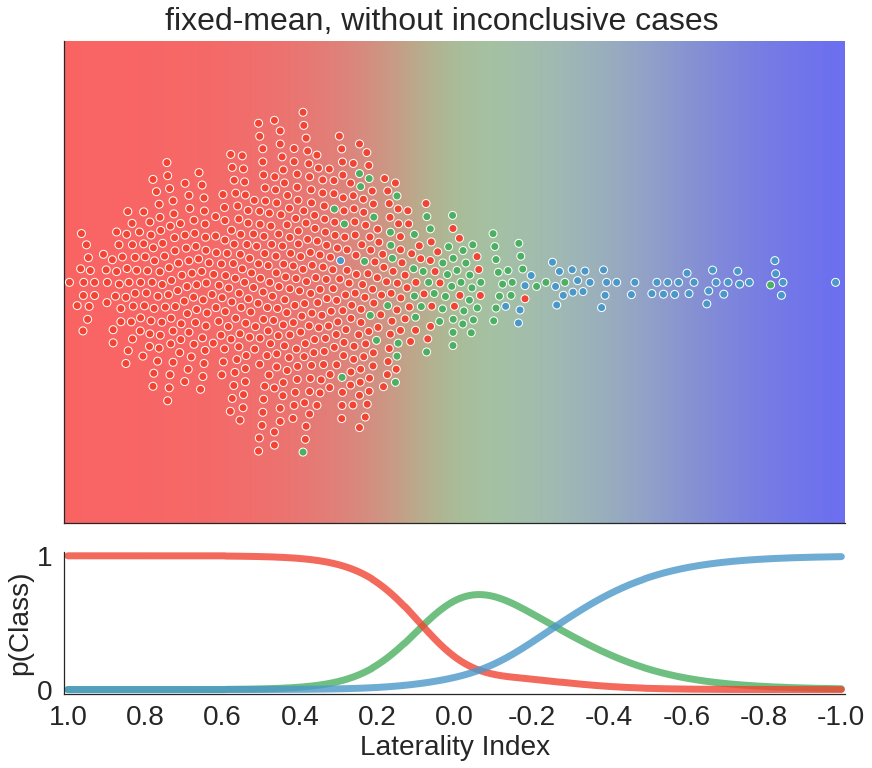

fixed-mean False


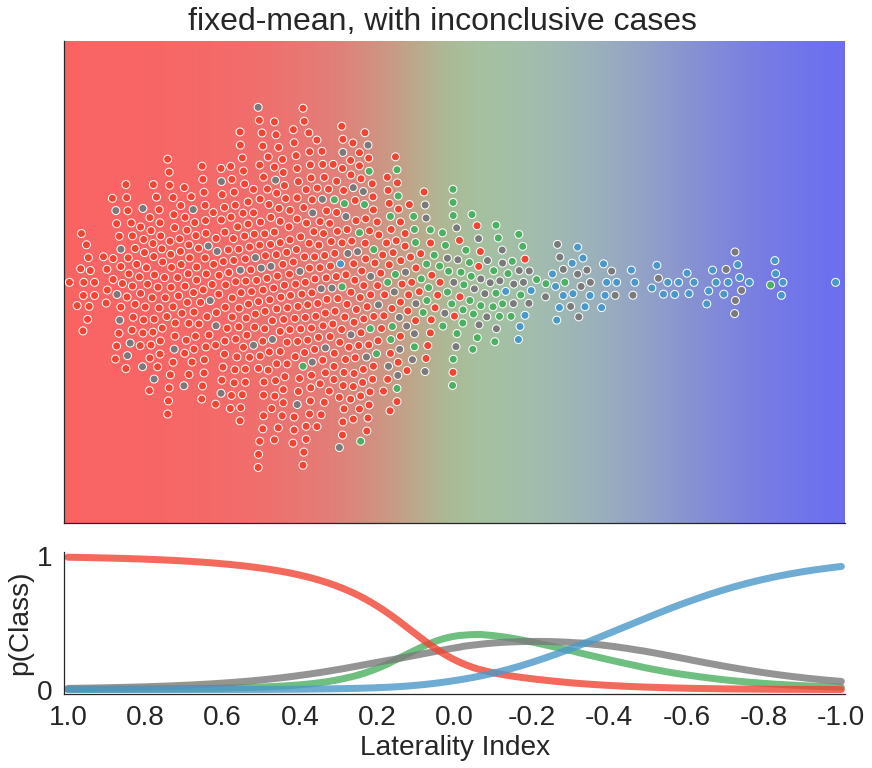

In [70]:
for c in mergeDf.columns.drop('clin'):
    for myDrop in [True, False]:
        print c, myDrop
        fig = bigPlotMaker(mergeDf,my_nest,c,drop=myDrop)

## Show relationship of LI-Toolbox LI's to each other

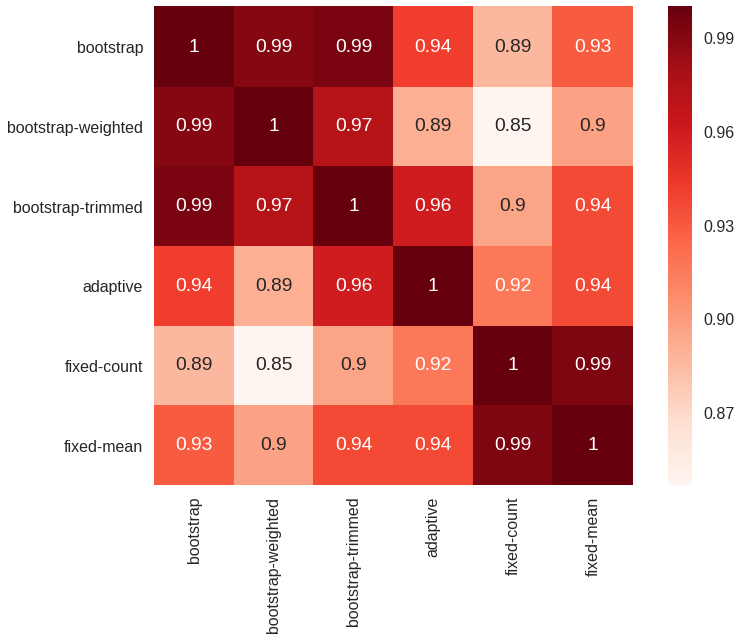

In [71]:
sns.heatmap(mergeDf.corr(),annot=True,square=True,cmap='Reds')

### show relationship of different LIs

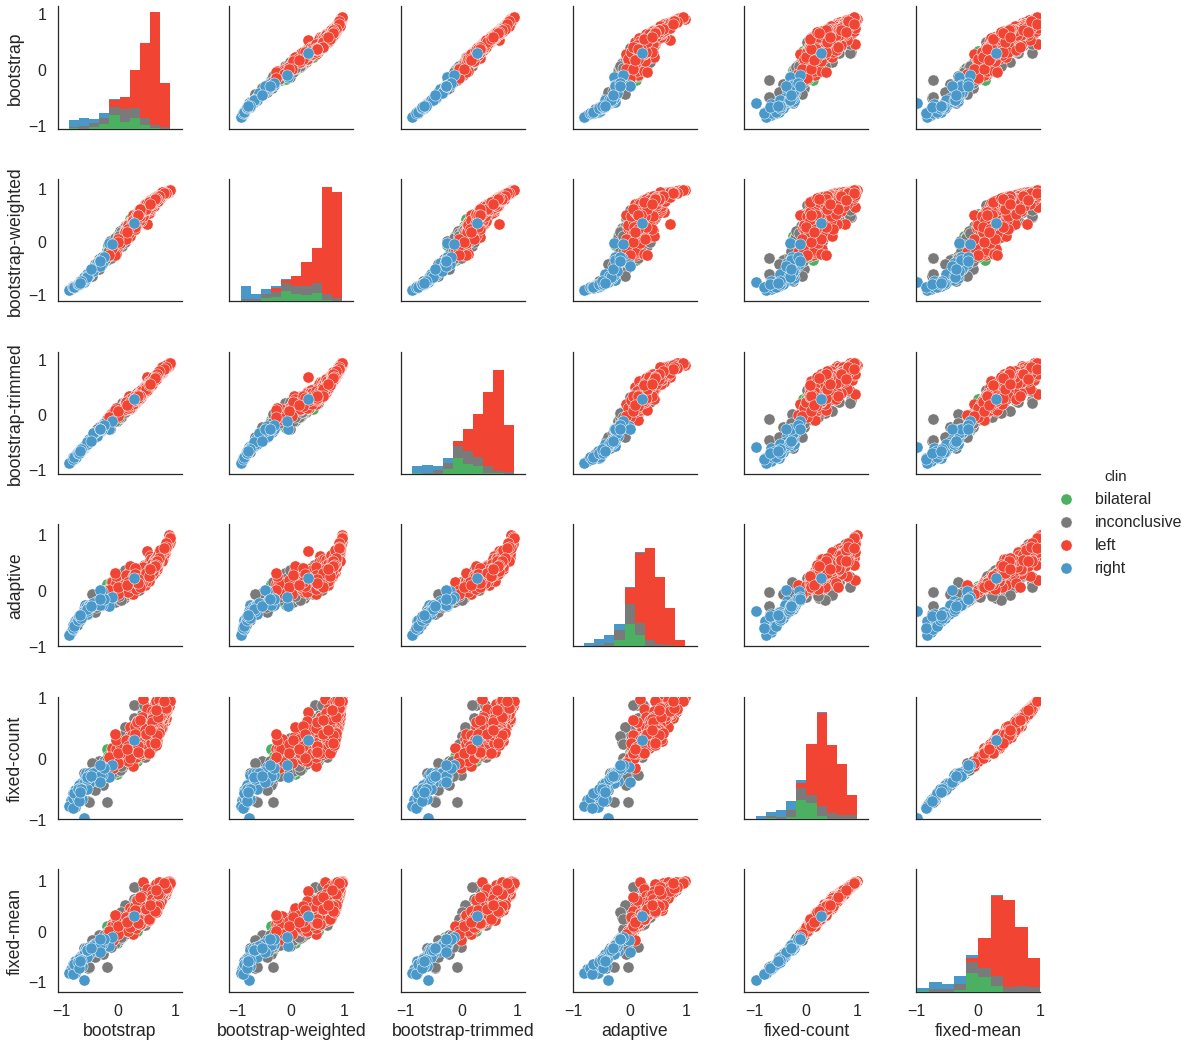

In [72]:
plt.figure(figsize=(12,12))
sns.pairplot(mergeDf.dropna(),
             hue='clin',
             #hue_order=['left','right','bilateral','inconclusive'],
             palette=cList)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

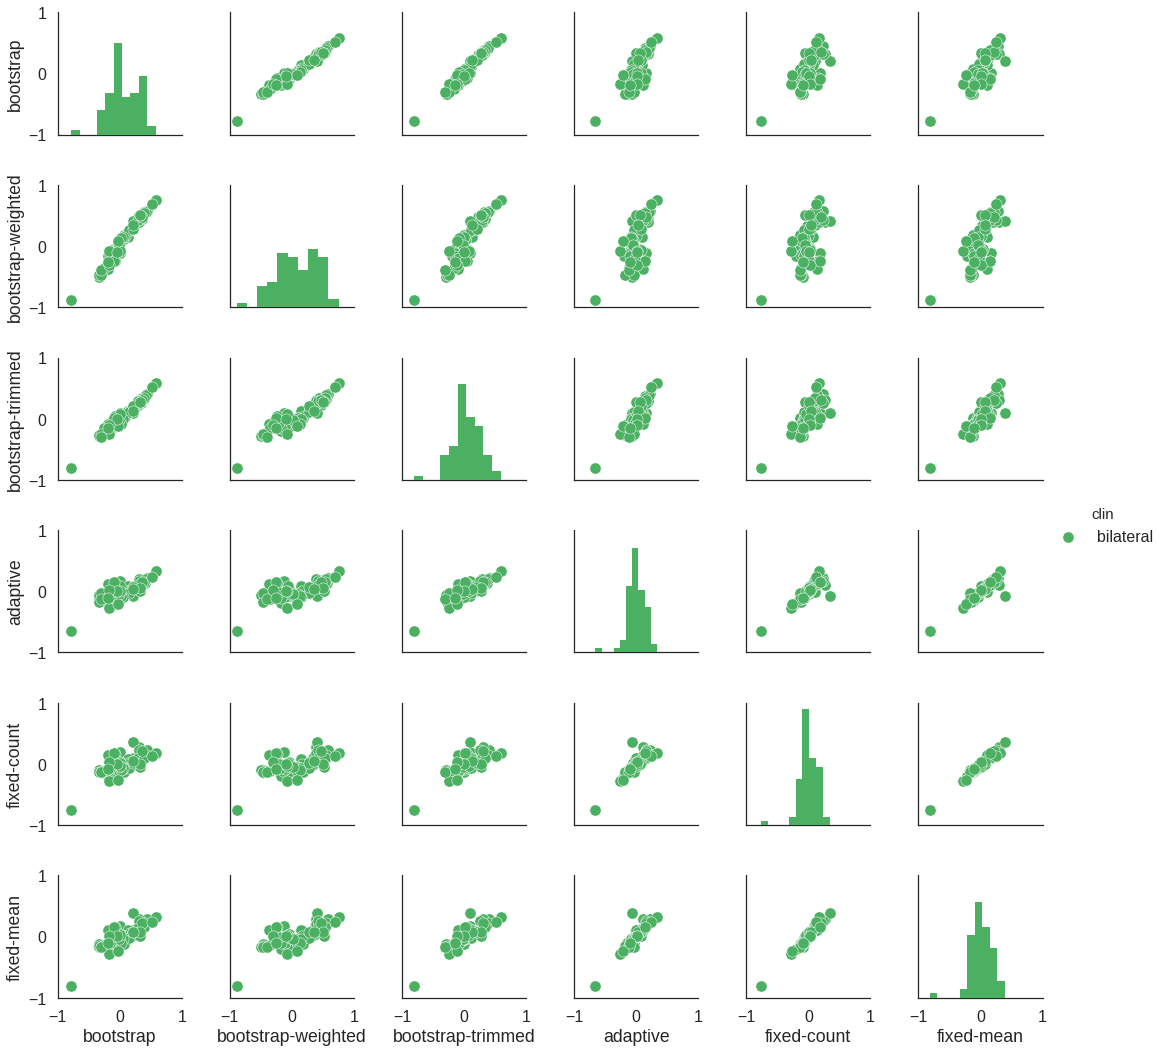

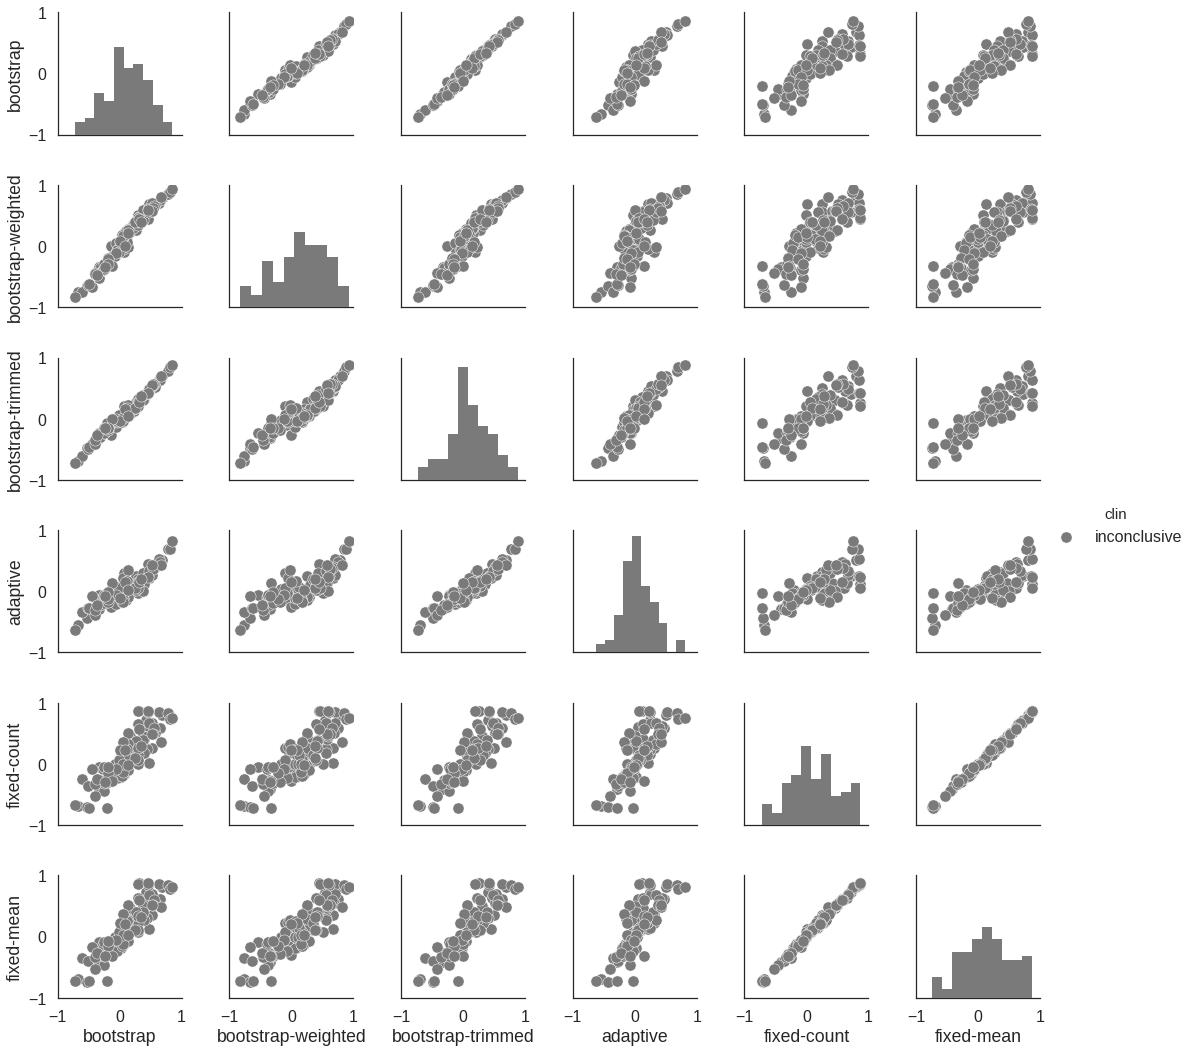

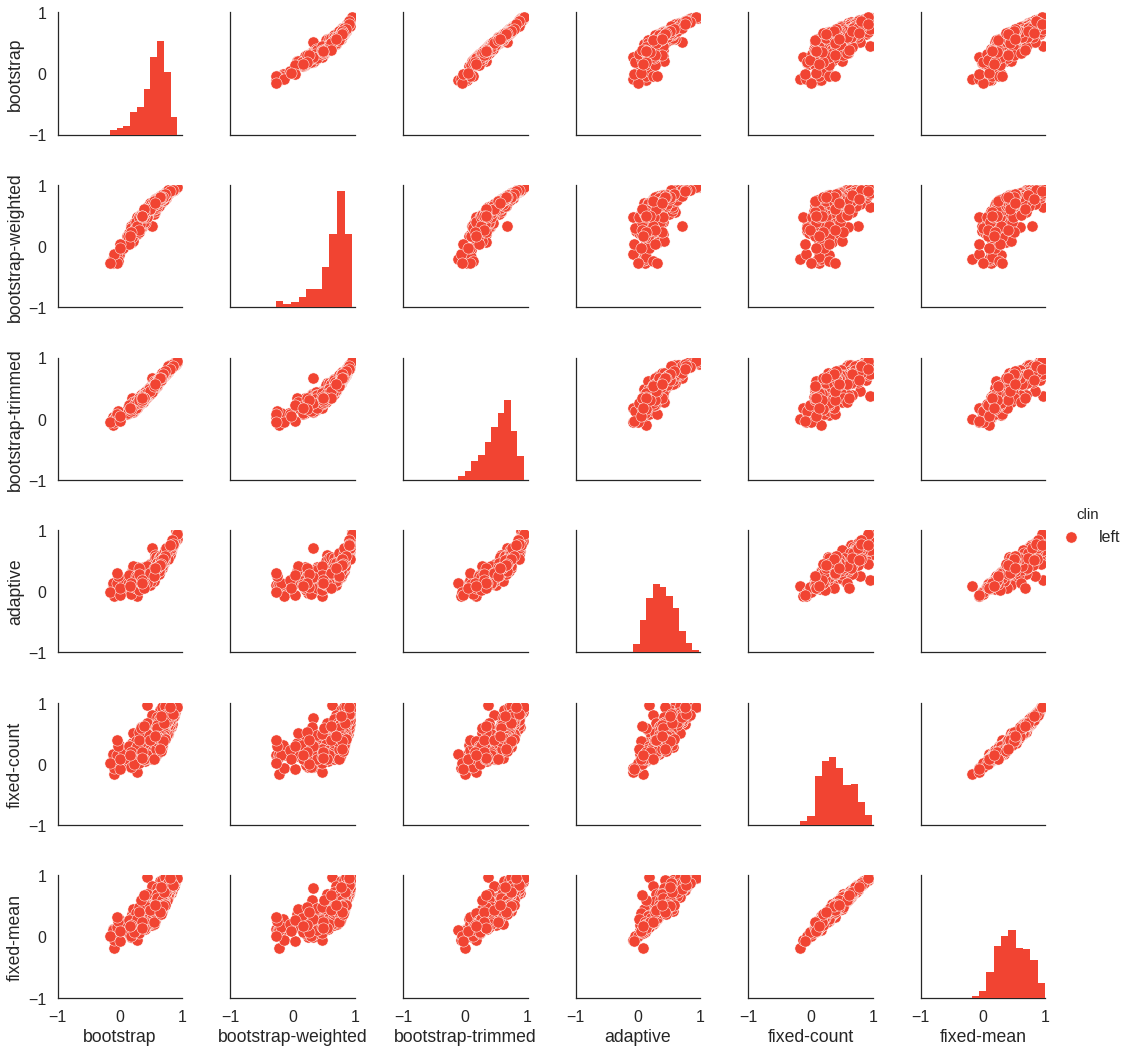

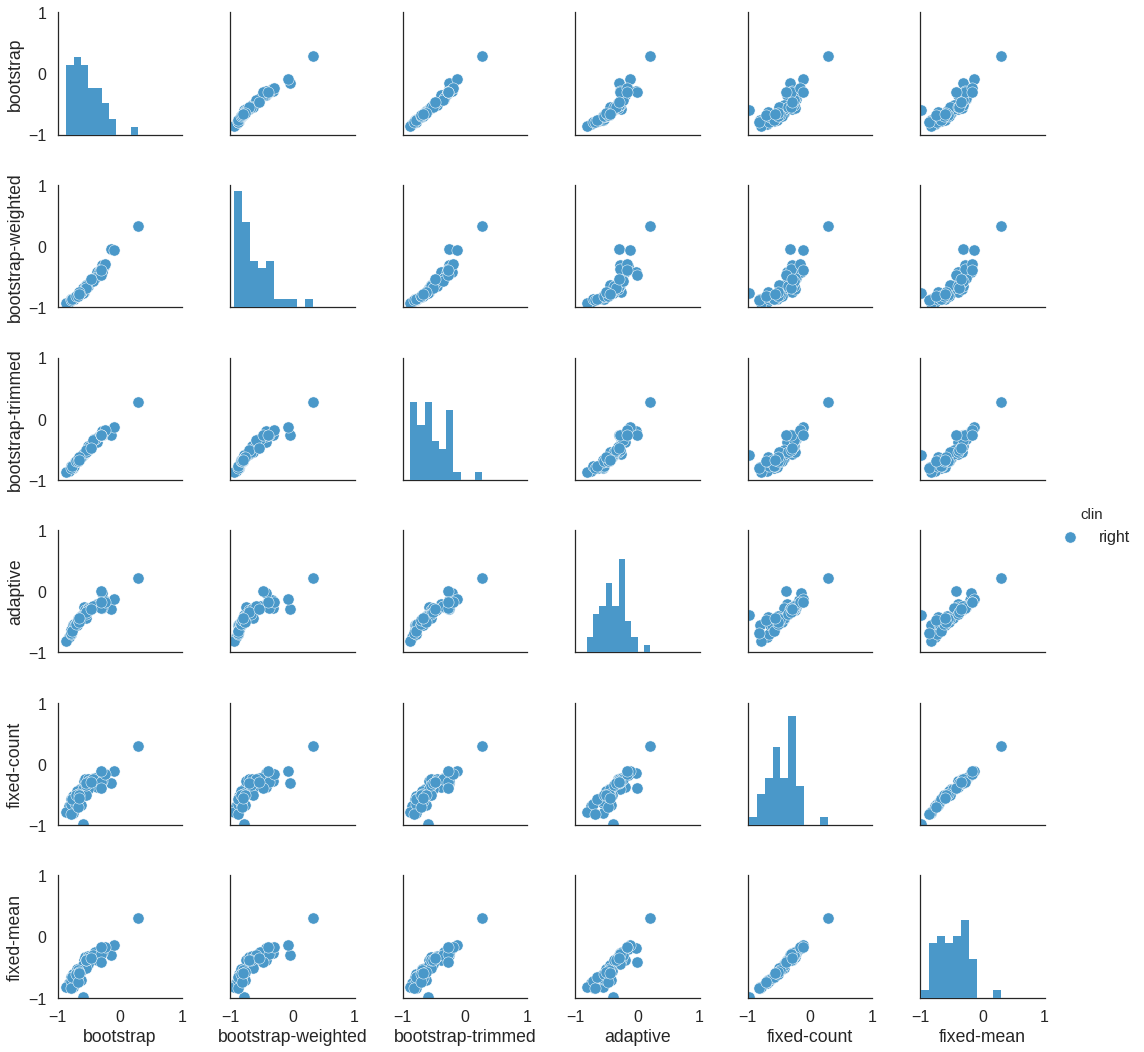

In [73]:
for n,i in enumerate(mergeDf.index.levels[0]):
    plt.figure(figsize=(12,12))
    pp = sns.pairplot(mergeDf.loc[i].dropna(),
                 hue='clin',
                 #hue_order=['left','right','bilateral','inconclusive'],
                 palette=[cList[n]])
    
    axes = pp.axes
    for a in axes: 
        for b in a: 
            b.set_xlim(-1,1);b.set_ylim(-1,1)

    plt.show()

### show distribution of inconclusive cases

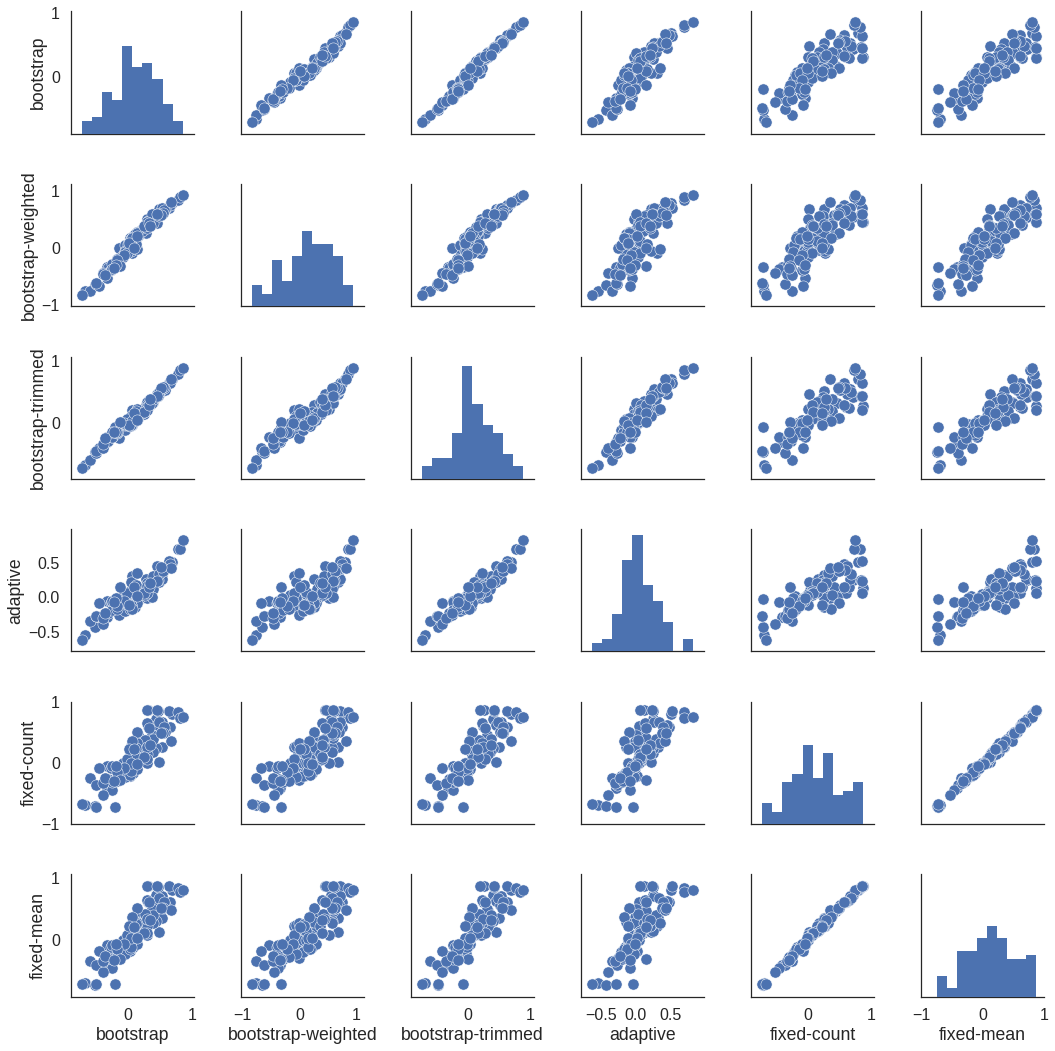

In [74]:
plt.figure(figsize=(12,12))
sns.pairplot(mergeDf.loc['inconclusive'].dropna() );
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

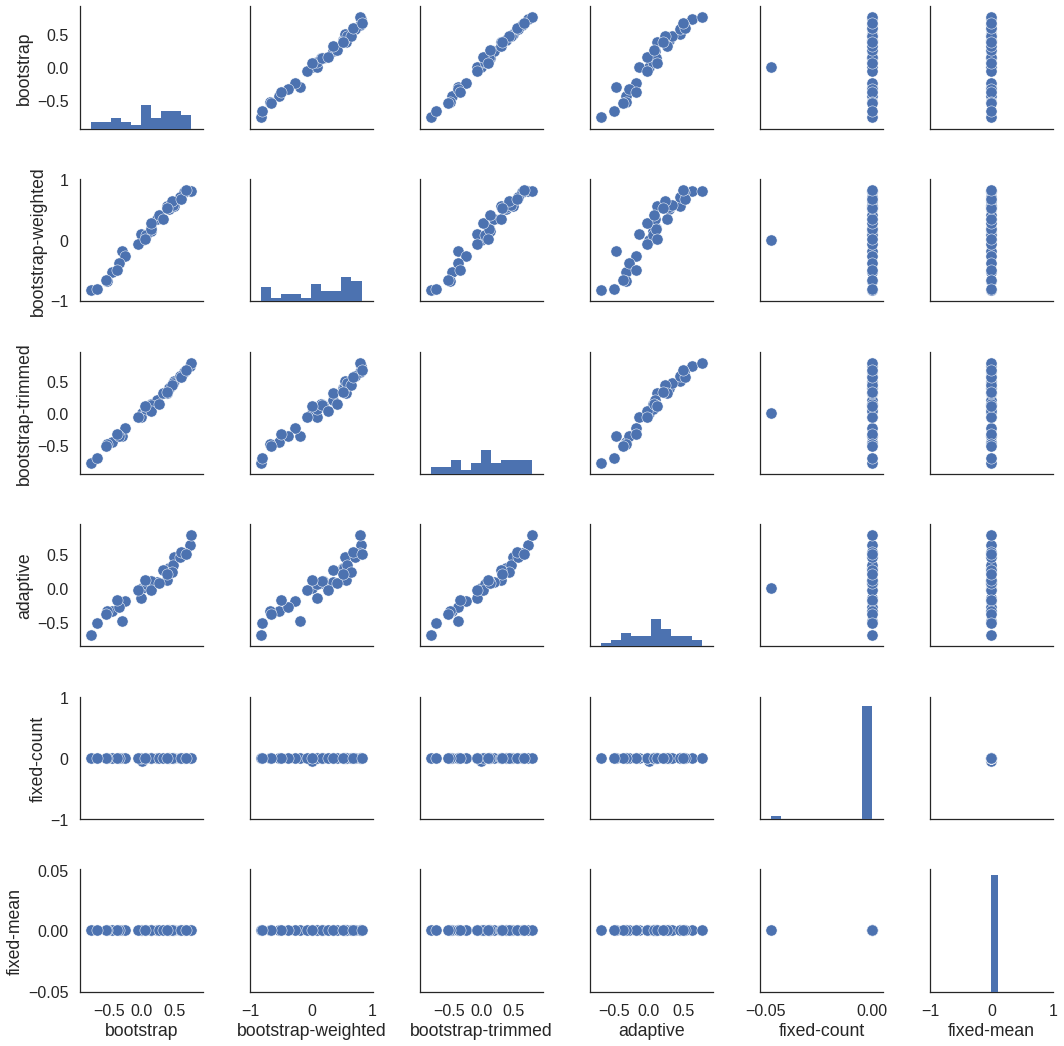

In [75]:
f = lambda x:np.isnan(x)
fu = mergeDf[mergeDf.drop('clin',axis=1).applymap(f).max(axis=1)]
plt.figure(figsize=(12,12))
sns.pairplot( fu.fillna(0) );
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()